# Transferability

Section 1: set up models

In [ ]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 890kB 6.6MB/s 
     |████████████████████████████████| 21.6MB 10.7MB/s 
     |████████████████████████████████| 235kB 57.6MB/s 
     |████████████████████████████████| 6.8MB 48.5MB/s 
     |████████████████████████████████| 747kB 53.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# From ATTA
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline

In [ ]:
# Step 0: Define the neural network model, return logits instead of activation in forward method

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

# Step 2: Create the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)


In [ ]:
# set up PGD-20 attack
eps = 0.2
attack = ProjectedGradientDescentPyTorch(
        estimator=classifier,
        norm="inf",
        eps=eps,
        eps_step=0.05,
        max_iter=20
    )

Section 2: using PGD-20 to adversarially train a classifier

In [ ]:
# Step 4: Adv train, get T1

x_train_adv_1 = attack.generate(x=x_train)
classifier.fit(x_train_adv_1, y_train, batch_size=64, nb_epochs=1)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:525: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:526: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


Accuracy on benign test examples: 96.87%


In [ ]:
y_label = np.argmax(y_train, axis=1)
y_label_tensor = torch.from_numpy(y_label.astype(np.int_)).to(device)

# Calculate loss
adv_predictions_1 = classifier.predict(x_train_adv_1)
x_adv_tensor = torch.from_numpy(x_train_adv_1).to(device)
loss_adv_1 = criterion(model(x_adv_tensor), y_label_tensor)
err_adv_1 = np.sum(np.argmax(adv_predictions_1, axis=1) != np.argmax(y_train, axis=1))
accuracy = 1 - err_adv_1 / len(y_train)
print(loss_adv_1, err_adv_1, accuracy)

tensor(0.1039, device='cuda:0', grad_fn=<NllLossBackward>) 1962 0.9673


In [ ]:
# Adv Epoch 2

x_train_adv_2 = attack.generate(x=x_train)
classifier.fit(x_train_adv_2, y_train, batch_size=64, nb_epochs=1)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# Calculate loss
adv_predictions_2 = classifier.predict(x_train_adv_2)
x_adv_tensor = torch.from_numpy(x_train_adv_2).to(device)
loss_adv_2 = criterion(model(x_adv_tensor), y_label_tensor)
err_adv_2 = np.sum(np.argmax(adv_predictions_2, axis=1) != np.argmax(y_train, axis=1))
print("adv epoch 2 :", loss_adv_2)

/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:525: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:526: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


Accuracy on benign test examples: 96.33%
adv epoch 2 : tensor(0.1914, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
# Adv Epoch 3

x_train_adv_3 = attack.generate(x=x_train)
classifier.fit(x_train_adv_3, y_train, batch_size=64, nb_epochs=1)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# Calculate loss
adv_predictions_3 = classifier.predict(x_train_adv_3)
x_adv_tensor = torch.from_numpy(x_train_adv_3).to(device)
loss_adv_3 = criterion(model(x_adv_tensor), y_label_tensor)
err_adv_3 = np.sum(np.argmax(adv_predictions_3, axis=1) != np.argmax(y_train, axis=1))
print("adv loss epoch 3 :", loss_adv_3)

/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:525: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:526: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


Accuracy on benign test examples: 96.38%
adv loss epoch 3 : tensor(0.1277, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
# Adv Epoch 4

x_train_adv_4 = attack.generate(x=x_train)
classifier.fit(x_train_adv_4, y_train, batch_size=64, nb_epochs=1)

# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

# Calculate loss
adv_predictions_4 = classifier.predict(x_train_adv_4)
x_adv_tensor = torch.from_numpy(x_train_adv_4).to(device)
loss_adv_4 = criterion(model(x_adv_tensor), y_label_tensor)
print("adv loss epoch 4 :", loss_adv_4)

/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:525: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.6/dist-packages/art/estimators/classification/pytorch.py:526: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


Accuracy on benign test examples: 97.05%
adv loss epoch 4 : tensor(0.1232, device='cuda:0', grad_fn=<NllLossBackward>)


Section 3: calculate the loss and error transferability 

In [ ]:
loss_ratios = []
err_ratios = []
# calculate loss(adv1, T4)/loss(adv1, T1)
x_adv_tensor = torch.from_numpy(x_train_adv_1).to(device)
loss_adv_14 = criterion(model(x_adv_tensor), y_label_tensor)
ls14 = loss_adv_14.cpu().clone().detach().numpy()
ls11 = loss_adv_1.cpu().clone().detach().numpy()
loss_ratios.append(ls14/ls11)

# calculate err(adv1, T4)/err(adv1, T1)
adv_predictions_14 = classifier.predict(x_train_adv_1)
err_adv_14 = np.sum(np.argmax(adv_predictions_14, axis=1) != np.argmax(y_train, axis=1))
err_ratios.append(err_adv_14/err_adv_1)

# calculate loss(adv2, T4)/loss(adv2, T2)
x_adv_tensor = torch.from_numpy(x_train_adv_2).to(device)
loss_adv_24 = criterion(model(x_adv_tensor), y_label_tensor)
ls24 = loss_adv_24.cpu().clone().detach().numpy()
ls22 = loss_adv_2.cpu().clone().detach().numpy()
loss_ratios.append(ls24/ls22)

# calculate err(adv2, T4)/err(adv2, T2)
adv_predictions_24 = classifier.predict(x_train_adv_2)
err_adv_24 = np.sum(np.argmax(adv_predictions_24, axis=1) != np.argmax(y_train, axis=1))
err_ratios.append(err_adv_24/err_adv_2)

# calculate loss(adv3, T4)/loss(adv3, T3)
x_adv_tensor = torch.from_numpy(x_train_adv_3).to(device)
loss_adv_34 = criterion(model(x_adv_tensor), y_label_tensor)
ls34 = loss_adv_34.cpu().clone().detach().numpy()
ls33 = loss_adv_3.cpu().clone().detach().numpy()
loss_ratios.append(ls34/ls33)

# calculate err(adv3, T4)/err(adv3, T3)
adv_predictions_34 = classifier.predict(x_train_adv_3)
err_adv_34 = np.sum(np.argmax(adv_predictions_34, axis=1) != np.argmax(y_train, axis=1))
err_ratios.append(err_adv_34/err_adv_3)



In [ ]:
print("loss_trans:\t", loss_ratios)
print("err_trans:\t", err_ratios)

loss_trans:	 [1.0919508, 1.1078461, 5.1655426]
err_trans:	 [1.081039755351682, 1.1045343469997284, 5.048212133386903]


In [ ]:
loss_trans = []
err_trans = []
for i in range(len(loss_ratios)):
  loss_trans.append(1/loss_ratios[i])
  err_trans.append(1/err_ratios[i])

print("loss_trans:\t", loss_trans)
print("err_trans:\t", err_trans) 

loss_trans:	 [0.915792198360973, 0.9026524199672301, 0.19359050480165657]
err_trans:	 [0.925035360678925, 0.9053588987217306, 0.19808993235177078]


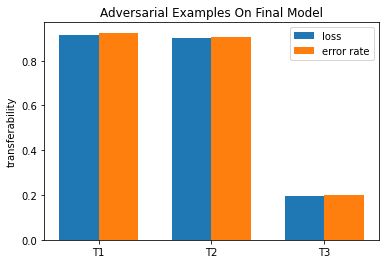

In [ ]:
ind = np.arange(len(loss_trans))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, loss_trans, width, label='loss')
rects2 = ax.bar(ind + width/2, err_trans, width, label='error rate')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('transferability')
ax.set_title('Adversarial Examples On Final Model')
ax.set_xticks(ind)
ax.set_xticklabels(('T1', 'T2', 'T3'))
ax.legend()

fig.savefig('AdversarialExamplesOnFinalModel.jpg')